<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/tfsts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF.Prob Structured Time Series

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce

from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
TF_Installation = 'TF Nightly' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

     |████████████████████████████████| 520.7MB 25kB/s 
     |████████████████████████████████| 460kB 43.7MB/s 
     |████████████████████████████████| 2.9MB 42.0MB/s 
Installation of `tf-nightly` complete.


In [0]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

## **Import & Preprocess Financial Time Series**

In [0]:
# Import data
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)

In [0]:
# Preprocess series
data = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
data = data.set_index('Date')
series = data
series.head()

,Close
Date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


# **Exploratory Data Analysis**

* Is there a seasonality?
* Is there a trend?
* Is there autocorrelation present?

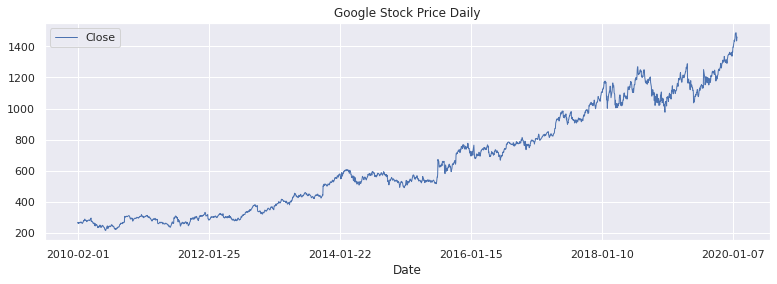

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.0,title='Google Stock Price Daily')

In [0]:
series.describe(percentiles=[0.05, 0.95])

,Close
count,2516.000000
mean,652.587282
std,331.360307
min,217.220810
5%,258.210923
50%,567.298034
95%,1216.795044
max,1486.650024


In [0]:
# Missing data?

**Is the series normally distributed?**

Hypothesis: no.

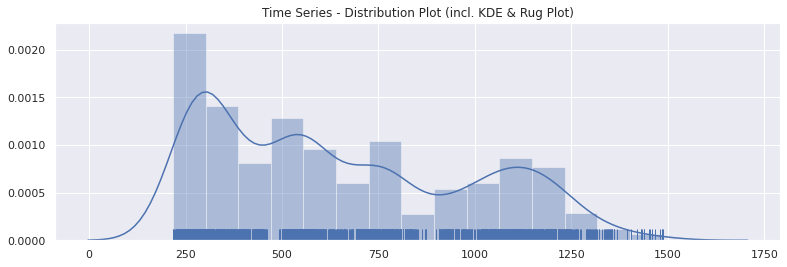

In [0]:

sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

Text(0.5, 1.0, 'White Noise Process - Boxplot')

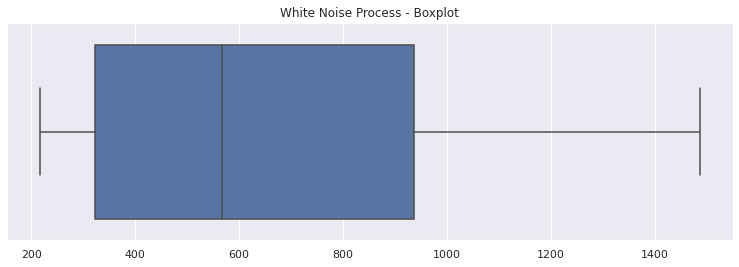

In [0]:
sns.boxplot(series).set_title('White Noise Process - Boxplot')

**Is there an autocorrelation?**

Hypothesis: Yes, with lag 1. Most financial time series are similar to markov processes with a dependency on one lag.

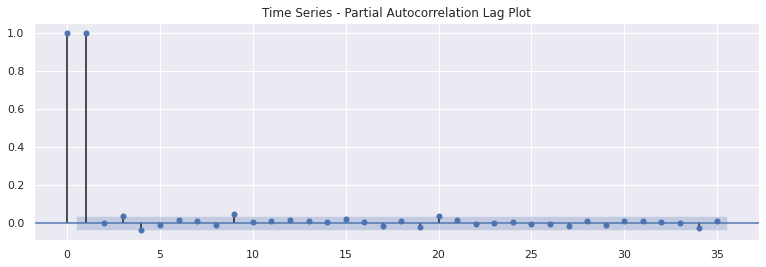

In [0]:
plot_pacf(series)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


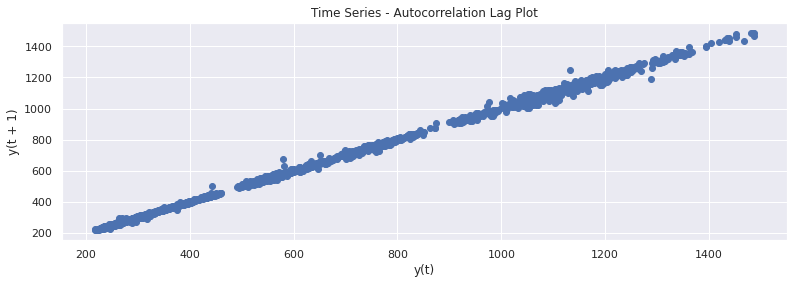

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

**Is the time series stationary?**

Hypohesis: It isn't. Most financial time series exhibit a unit root and need to be differenced once. Additionally they demonstrate a trend upward ('random walk with drift'). Also there might some seasonality.

In [0]:
# Augmented Dickery Fuller (H0: No stationarity)
statsmodels.tsa.stattools.adfuller(series, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

ValueError: ignored

# **Model Building**

In [0]:
observed_time_series = series

In [0]:
holiday_indicators = np.zeros([31, 3])
holiday_indicators[23, 0] = 1  # Christmas Eve
holiday_indicators[24, 1] = 1  # Christmas Day
holiday_indicators[30, 2] = 1  # New Year's Eve

holidays = tfp.sts.LinearRegression(design_matrix=holiday_indicators,
                                    name='holidays')
day_of_week = tfp.sts.Seasonal(num_seasons=7,
                               observed_time_series=observed_time_series,
                               name='day_of_week')

In [0]:
model = tfp.sts.Sum(components=[holidays, seasonal],
                    observed_time_series=observed_time_series)